In [4]:
import urllib.request
import collections
import math
import os
import random
import zipfile
import datetime as dt
import numpy as np
import tensorflow as tf
import pandas as pd
import nltk
import re
from string import punctuation
import matplotlib.pyplot as plt
from nltk.util import ngrams
from itertools import chain


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#tf.enable_eager_execution()

In [5]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

def build_dataset(words, n_words): # n_words is the size of the vocabulary that we want taken as 10000 here
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]] # initialise a list that counts the occurance of each word
    count.extend(collections.Counter(words).most_common(n_words - 1)) # fill the list with each word count as a tuple (word, word_count)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary) # create a dictionary where keys are the words and their values are their rank of counts eg. as:1 if as is ranked 1 in the count list
    data = list()
    unk_count = 0
    # the created index for each word (based on its count rank) is now stored in the list named "data"
    for word in words:
        if word in dictionary:
            index = dictionary[word] # index of the word being initialised as per the count of the word
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index) # contains index of each word based on its count rank 
                        # BUT NOTE THE INDEX ARE NOT ORDERED AS PER COUNTS AND PRESERVE THEIR ORIGNINAL ORDER IN THE SENTENCES
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def collect_data(vocabulary_size=12988):
    filename = 'filename.zip' # INPUT THE file name
    vocabulary = read_data(filename) #returns a list of all words in the text file
    print(vocabulary[:7])
    data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                                vocabulary_size) # Provide the list of words and vocabulary size to create the dataset
    del vocabulary  # Hint to reduce memory.
    # the data contains list of indexes of each word as per their occurence sequence in the text file
    # Try printing print(reverse_dictionary[5234],reverse_dictionary[3081],reverse_dictionary[12],reverse_dictionary[6],reverse_dictionary[195]) 
    
    # the count is a list of tuples (word, word_count)
    # dictionary contains keys as words and their index as values
    # dictionary contains keys as index and their corresponding words as values
    
    return data, count, dictionary, reverse_dictionary

data_index = 0 # initialize data index and maake it global to use in the function bellow
# generate batch data
def generate_batch(data, batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0 # proceed only if the condition is true " BATCH SIZE IS A MULTIPLE OF num_skips"
    assert num_skips <= 2 * skip_window # number of words to be randomly picked from surrounding the context word should be less than equal to skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32) # initialize a nd.array for the batch of input with size (batch_size,) eg. (128,)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32) # initialize a nd.array for the context with size (batch_size,1) 
                    # eg. (128, 1) to hold index of context words for each word (index) in batch array([[  18],[  18],[   1],[   1],..])
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]
    buffer = collections.deque(maxlen=span) # A double ended queu where elements can be added or subtracted from both ends
    for _ in range(span):
        buffer.append(data[data_index]) # data_index is initiallized by 0 outsuide the function
        data_index = (data_index + 1) % len(data) # after this step in the buffer 5 words are stored based on their index in the supplied data list
                            # The data list contains index of each word in the order of sequence they occur in the text and thus it preserve the order of the context 
    for i in range(batch_size // num_skips): # batch_size divided by num_skips =128/2 = 64
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1) #generates a random integer between 0-4 so that the index of the words surrounding the input word can be obtained
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word ## at the between of the buffer
            context[i * num_skips + j, 0] = buffer[target]  # these are the context words
        buffer.append(data[data_index]) # find the comment bellow
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, context

'''
This buffer will hold a maximum of span elements and will be a kind of moving window of words that samples are drawn from. 
Whenever a new word index is added to the buffer, the left most element will drop out of the buffer to allow room for the new 
word index being added.  The position of the buffer in the input text stream is stored in a global variable data_index which is
incremented each time a new word is added to the buffer.  If it gets to the end of the text stream, the “% len(data)” component 
of the index update will basically reset the count back to zero.
'''

vocabulary_size=12988
data, count, dictionary, reverse_dictionary = collect_data(vocabulary_size=12988)

['during', 'trip', 'operation', 'damage', 'wa', 'observe', 'on']


In [3]:
len(dictionary)

12988

In [79]:
reverse_dictionary.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [3]:
batch_size = 128
embedding_size = 100  # Dimension of the embedding vector.
skip_window = 5       # How many words to consider left and right.
num_skips = 0         # How many times to reuse an input to generate a label. 

## By reading the blog the understanding of num_skips is that this parameter suggests the
## number of words to be randomly picked from the words in the context neighborhood of 'sat'



# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 15    # Number of negative examples to sample.

In [6]:
valid_examples

array([1754, 5543, 1698, 3249,  418, 4896,  332, 1091,  743, 6003, 2355,
       3739,  101, 8546, 1563, 5480, 2405, 7834, 9142, 2670])

In [ ]:
import json
with open('equipment_dictionary.json', 'r') as fp:
    dictionary_mp_eqpt = json.load(fp)
dictionary_mp_eqpt    

In [ ]:
for key in dictionary_mp_eqpt.keys():
    dictionary_mp_eqpt[key].append(key)
dictionary_mp_eqpt

In [ ]:
dictionary_mp_eqpt['tool_control'].append('programmable_logic_control')
dictionary_mp_eqpt['motor_cooling_system'].append('duct')
dictionary_mp_eqpt['motor_cooling_system'].append('air_duct')
dictionary_mp_eqpt['motor_cooling_system'].append('arrestor')
rem_ = ['fastener','seal']
for v in dictionary_mp_eqpt.values():
    for r_v in rem_:
        if r_v in v:
            v.remove(r_v)
print(dictionary_mp_eqpt)

In [ ]:
l1 = [*dictionary_mp_eqpt.values()]
l1_flat =  [item for sublist in l1 for item in sublist]
l2 = [*dictionary.keys()]
l3 = list(set(l1_flat)&set(l2))
print(l3, l1_flat)

In [ ]:
subset_dictionary = {k: dictionary[k] for k in dictionary.keys() & l3}
subset_dictionary

In [11]:
dict_indices_of_taxonomy = {}
for key in dictionary_mp_eqpt.keys():
    values = dictionary_mp_eqpt[key]
    indices_list = []
    for val in values:
        if val in l3:
            ind = subset_dictionary[val]
            indices_list.append(ind)
    dict_indices_of_taxonomy[key] = indices_list
dict_indices_of_taxonomy

{'drive_motor_assembly': [483, 118, 8511, 672, 573, 3868, 304, 1298],
 'fluid_end': [1912,
  237,
  430,
  200,
  789,
  10972,
  341,
  1114,
  518,
  3389,
  582,
  1259,
  1373,
  2315,
  253,
  421,
  211,
  495],
 'motor_cooling_system': [6213,
  2384,
  964,
  3229,
  99,
  1979,
  198,
  6788,
  2433,
  3123,
  1612],
 'power_end': [3031, 3913, 6066, 4860, 506, 538, 276, 306, 345, 2419, 1999],
 'tool_control': [350, 471, 1372, 1303, 2448, 1701, 107, 177, 190]}

In [12]:
all_index_lst = [dict_indices_of_taxonomy[key] for key in dict_indices_of_taxonomy.keys()]
all_index_lst

[[483, 118, 8511, 672, 573, 3868, 304, 1298],
 [1912,
  237,
  430,
  200,
  789,
  10972,
  341,
  1114,
  518,
  3389,
  582,
  1259,
  1373,
  2315,
  253,
  421,
  211,
  495],
 [6213, 2384, 964, 3229, 99, 1979, 198, 6788, 2433, 3123, 1612],
 [3031, 3913, 6066, 4860, 506, 538, 276, 306, 345, 2419, 1999],
 [350, 471, 1372, 1303, 2448, 1701, 107, 177, 190]]

In [13]:
def fetch_embeddings (embeddings, list_indices):
    embed_subset = tf.nn.embedding_lookup(embeddings, list_indices) #subsetting the embeddings for the words to cluster
    normalized = tf.nn.l2_normalize(embed_subset, dim = 1)
    prod = tf.matmul(normalized, normalized,adjoint_b = True) # transpose second matrix)
    dist = 1 - prod
    upper_triang = tf.matrix_band_part(dist, 0, -1)
    distance_measure = tf.math.reduce_sum(upper_triang)
    return distance_measure

In [14]:
# We would reduce the embeddings to their centroid and then take the dot product between the centroids
def dissimilarity_bw_embedings (embeddings, l1, l2):
    embed_subset_1 = tf.nn.embedding_lookup(embeddings, l1)
    embed_subset_2 = tf.nn.embedding_lookup(embeddings, l2)
    embed_mean_1  = tf.reduce_mean(embed_subset_1,0)
    embed_mean_2  = tf.reduce_mean(embed_subset_2,0)
    # we would return te similarity between the 2 ectors as we need to minimize 
    # the similarity i.e., increase the distance between their means
    sim= 1 - tf.losses.cosine_distance(tf.nn.l2_normalize(embed_mean_1,0),tf.nn.l2_normalize(embed_mean_2,0),dim =0)
    return sim

In [28]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[None])
    train_context = tf.placeholder(tf.int32, shape=[None, 1])
    
    input_1 = tf.placeholder(tf.int32, shape=(None))# indices of words to cluster together
    input_2 = tf.placeholder(tf.int32, shape=(None))
    input_3 = tf.placeholder(tf.int32, shape=(None))
    input_4 = tf.placeholder(tf.int32, shape=(None))
    input_5 = tf.placeholder(tf.int32, shape=(None))

    

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    lr = tf.placeholder(tf.float32)
    alpha_ =  tf.placeholder(tf.float32)
    one_min_alp = 1-alpha_
  # Look up embeddings for inputs.
    print(embedding_size)
    print(batch_size)
    embeddings = tf.Variable(
      tf.random_normal([vocabulary_size, embedding_size], 0.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
   
    
    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.random_normal([vocabulary_size, embedding_size],stddev=1.0, mean=0.0 ))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    distance_1 = fetch_embeddings(embeddings, input_1)
    distance_2 = fetch_embeddings(embeddings, input_2)
    distance_3 = fetch_embeddings(embeddings, input_3)
    distance_4 = fetch_embeddings(embeddings, input_4)
    distance_5 = fetch_embeddings(embeddings, input_5)

    dis_pair_1 = dissimilarity_bw_embedings(embeddings, input_1, input_2)
    dis_pair_2 = dissimilarity_bw_embedings(embeddings, input_1, input_3)
    dis_pair_3 = dissimilarity_bw_embedings(embeddings, input_1, input_4)
    dis_pair_4 = dissimilarity_bw_embedings(embeddings, input_1, input_5)

    
    dis_pair_5 = dissimilarity_bw_embedings(embeddings, input_2, input_3)
    dis_pair_6 = dissimilarity_bw_embedings(embeddings, input_2, input_4)
    dis_pair_7 = dissimilarity_bw_embedings(embeddings, input_2, input_5)

    
    dis_pair_8 = dissimilarity_bw_embedings(embeddings, input_3, input_4)
    dis_pair_9 = dissimilarity_bw_embedings(embeddings, input_3, input_5)

    
    dis_pair_10 = dissimilarity_bw_embedings(embeddings, input_4, input_5)
    
    cum_distance_loss = tf.add_n([distance_1,distance_2,distance_3,distance_4,distance_5,
                                  dis_pair_1,dis_pair_2,dis_pair_3,dis_pair_4,dis_pair_5,dis_pair_6,dis_pair_7,dis_pair_8,
                                  dis_pair_9,dis_pair_10])

    distance_product = tf.math.multiply(one_min_alp,cum_distance_loss)
    ### tf.add_n([tf.math.multiply(0.2,
    nce_loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))
    nce_loss_prod = tf.math.multiply(alpha_,nce_loss)    
    oveall_loss =  tf.add_n([distance_product,nce_loss_prod])
    
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(lr,global_step,200, 0.875, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(oveall_loss)
    
    # Compute the cosine similarity between minibatch examples and all embeddings.
    
    # norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    
    # normalized_embeddings = embeddings / norm
    
    #valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    valid_embeddings = tf.nn.embedding_lookup(embeddings, valid_dataset)
    #similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    similarity = tf.matmul(valid_embeddings, embeddings, transpose_b=True)
    

    # Add variable initializer.
    init = tf.global_variables_initializer() 

100
256
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
dim is deprecated, use axis instead


In [29]:
[*dict_indices_of_taxonomy.keys()]

['drive_motor_assembly',
 'fluid_end',
 'motor_cooling_system',
 'power_end',
 'tool_control']

In [30]:
loss_ = []
def run(graph, num_steps, lr_,alpha, batch_size_, num_skips, skip_window, embedding_size_):
    loss_ = []
    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
        
        init.run()
        print('Initialized')

        average_loss = 0
        l1 = dict_indices_of_taxonomy['drive_motor_assembly']
        l2 = dict_indices_of_taxonomy['motor_cooling_system']
        l3 = dict_indices_of_taxonomy['power_end']
        l4 = dict_indices_of_taxonomy["fluid_end"]
        l5 = dict_indices_of_taxonomy["tool_control"]
        
        
        for step in range(num_steps):
            batch_inputs, batch_context = generate_batch(data,
                batch_size, num_skips, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_context: batch_context, input_1:l1, input_2:l2, 
                         input_3:l3,input_4:l4,input_5:l5, lr:lr_, alpha_:alpha}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
            _, loss_val = session.run([optimizer, nce_loss], feed_dict=feed_dict) #Made a change here
            average_loss += loss_val
                
            if step % 1000 == 0:
                if step > 0:
                    average_loss /= 1000
                  # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    loss_.append(average_loss)
                    average_loss = 0
        
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
        final_embeddings = embeddings.eval()
        return final_embeddings, loss_
        
        #similarity_=similarity_score.eval()

In [31]:
loss=[]
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_5, loss = run(graph, num_steps,1,0.5,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))

Initialized
Nearest to dbdbw: stab, failing, crimping, angel, pusher, vela, minify, alarmingly,
Nearest to fleet: losk, cmo, grounding, die, point, parallelism, roughgly, porportional,
Nearest to xanplex: tig, pnarvx, inservoce, reuest, consuming, format, disovered, gent,
Nearest to bullock: download, corresponding, attend, nl, ware, facebook, desicion, deisloated,
Nearest to runway: kchief, mapping, limitto, anywhere, blu, drive_motor, deisolating, glass,
Nearest to durin: agreement, educate, reassembeling, ursine, momentum, conatiner, delrin, hydaulic,
Nearest to mori: materialscoordinatordindeepwatercom, explor, density, cubicle, shimmy, compartment, imagejpg, issuesmsg,
Nearest to suspension: cured, visualy, boro, aroung, nipped, tread, ro, sq,
Nearest to ml: escaping, hacksawed, austrium, goo, per, prim, calibrtion, sector,
Nearest to hqsopstibmc: accordance, drillingsuptdindeepwatercom, crossover, bwe, backlite, thui, puc, bear,
Nearest to rerouted: removable, haliburton, selecto

Average loss at step  31000 :  5.905689772963524
Average loss at step  32000 :  5.54572275018692
Average loss at step  33000 :  5.593308186292648
Average loss at step  34000 :  5.883896516561508
Average loss at step  35000 :  5.981620977401733
Average loss at step  36000 :  5.522225201845169
Average loss at step  37000 :  5.1000962094068525
Average loss at step  38000 :  5.265814375400543
Average loss at step  39000 :  5.440800542593002
Average loss at step  40000 :  5.347420321464538
Nearest to dbdbw: stab, failing, angel, crimping, vela, minify, alarmingly, noon,
Nearest to fleet: tc, losk, ton, die, cmo, grounding, parallelism, shoot,
Nearest to xanplex: tig, pnarvx, reuest, inservoce, consuming, disovered, format, tabbed,
Nearest to bullock: corresponding, desicion, download, attend, deisloated, dand, caption, seam,
Nearest to runway: kchief, mapping, limitto, anywhere, blu, deisolating, pedestal, fa,
Nearest to durin: educate, reassembeling, ursine, conatiner, momentum, hydaulic, 

Average loss at step  71000 :  3.8351904647350312
Average loss at step  72000 :  3.8938807908296584
Average loss at step  73000 :  4.073933507442474
Average loss at step  74000 :  3.744312587738037
Average loss at step  75000 :  3.6266397870779037
Average loss at step  76000 :  3.712095456838608
Average loss at step  77000 :  3.947241072177887
Average loss at step  78000 :  3.8785308582782747
Average loss at step  79000 :  3.50683611869812
Average loss at step  80000 :  3.669740324497223
Nearest to dbdbw: failing, stab, angel, crimping, vela, minify, alarmingly, noon,
Nearest to fleet: ton, grounding, noticeable, tc, correction, shoot, progress, beacon,
Nearest to xanplex: tig, reuest, pnarvx, consuming, inservoce, disovered, swiftly, tabbed,
Nearest to bullock: corresponding, desicion, deisloated, dand, seam, caption, ecov, ew,
Nearest to runway: kchief, limitto, mapping, anywhere, deisolating, blu, pedestal, fa,
Nearest to durin: educate, reassembeling, conatiner, ursine, hydaulic, m

Average loss at step  111000 :  3.48145905148983
Average loss at step  112000 :  3.3055478868484496
Average loss at step  113000 :  3.1402574623823165
Average loss at step  114000 :  3.225755753159523
Average loss at step  115000 :  3.397930123448372
Average loss at step  116000 :  3.4252326197624208
Average loss at step  117000 :  3.165252991914749
Average loss at step  118000 :  3.179594823598862
Average loss at step  119000 :  3.1649173954725267
Average loss at step  120000 :  3.446875143289566
Nearest to dbdbw: failing, stab, angel, crimping, vela, minify, alarmingly, noon,
Nearest to fleet: grounding, general, noticeable, correction, progress, reporting, ton, beacon,
Nearest to xanplex: tig, reuest, consuming, pnarvx, inservoce, disovered, swiftly, tabbed,
Nearest to bullock: corresponding, desicion, deisloated, dand, seam, caption, ecov, kdd,
Nearest to runway: kchief, limitto, mapping, anywhere, blu, deisolating, pedestal, fa,
Nearest to durin: educate, reassembeling, conatiner,

Average loss at step  151000 :  2.9209987329244615
Average loss at step  152000 :  3.047480685710907
Average loss at step  153000 :  3.1378242955207827
Average loss at step  154000 :  3.2022093778848646
Average loss at step  155000 :  3.0166572803258895
Average loss at step  156000 :  2.954149795293808
Average loss at step  157000 :  3.010450276970863
Average loss at step  158000 :  3.1950861879587173
Average loss at step  159000 :  3.207132197856903
NCE method took 588.917752 minutes to run 100 iterations


In [32]:
np.save('Embeddings_generated_alpha_5_17_JULY_ADAM', embeddings_alpha_5)

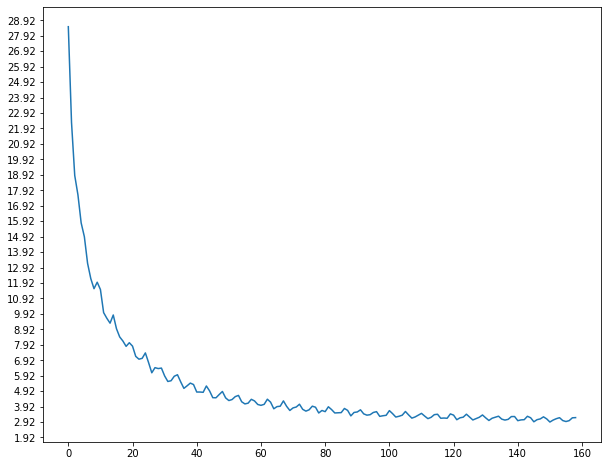

In [33]:
plt.figure(figsize=(10, 8))
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
#plt.yticks(0, len(loss)+1)
plt.show()

In [ ]:
num_steps = 160000
loss=[]
nce_start_time = dt.datetime.now()
embeddings_alpha_2, loss = run(graph, num_steps,1,0.2,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_2_17_JULY_ADAM', embeddings_alpha_2)
plt.figure(figsize=(10, 8))
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
plt.show()

Initialized
Nearest to dbdbw: awhr, casette, recertifcation, resest, influence, phone, neww, weater,
Nearest to fleet: convience, verbiage, transmiter, working, instructed, ibopo, sf, traker,
Nearest to xanplex: pretesting, hqstcsbstab, gbc, loud, addtional, tilt, ljx, centimeter,
Nearest to bullock: boxed, variate, revolve, cutin, too, fla, dozen, feather,
Nearest to runway: tuck, crossbarrw, thory, venture, kristandsand, verticle, deficiency, hpmp,
Nearest to durin: retie, resolution, equalized, automated, binding, attachedkw, pushbutton, autoclave,
Nearest to mori: apparent, ½, bchair, ring, retire, approve, enegized, gain,
Nearest to suspension: stand, now, matthew, sf, resolution, shack, hex, spilled,
Nearest to ml: availibility, retuned, clarify, slawek, redf, refrm, fittingwe, ptong,
Nearest to hqsopstibmc: succefully, registry, kt, smoothen, identifing, agasint, versa, barrel,
Nearest to rerouted: flx, counterbrace, psi, technique, tipical, cure, lollipop, remov,
Nearest to ro

Average loss at step  31000 :  6.4493410042524335
Average loss at step  32000 :  6.509498354673386
Average loss at step  33000 :  6.509058624982834
Average loss at step  34000 :  6.759872737884521
Average loss at step  35000 :  6.214958867073059
Average loss at step  36000 :  5.958753010511399
Average loss at step  37000 :  5.989240620374679
Average loss at step  38000 :  6.251323237895965
Average loss at step  39000 :  6.248296084165573
Average loss at step  40000 :  5.552283539056778
Nearest to dbdbw: awhr, casette, recertifcation, resest, influence, phone, weater, neww,
Nearest to fleet: verbiage, convience, instructed, working, transmiter, ibopo, sf, doinig,
Nearest to xanplex: pretesting, hqstcsbstab, gbc, loud, addtional, centimeter, ljx, tangjerd,
Nearest to bullock: boxed, variate, revolve, cutin, fla, dozen, feather, olk,
Nearest to runway: tuck, crossbarrw, thory, venture, kristandsand, verticle, hpmp, deficiency,
Nearest to durin: retie, resolution, equalized, automated, pus

Average loss at step  71000 :  4.229332932829857
Average loss at step  72000 :  4.546128708600998
Average loss at step  73000 :  4.156078595519066
Average loss at step  74000 :  3.989658208012581
Average loss at step  75000 :  3.930742077112198
Average loss at step  76000 :  4.260485387086868
Average loss at step  77000 :  4.432830532073974
Average loss at step  78000 :  3.961454674243927
Average loss at step  79000 :  4.002217581868171
Average loss at step  80000 :  3.905749652981758
Nearest to dbdbw: awhr, casette, recertifcation, resest, influence, phone, weater, neww,
Nearest to fleet: verbiage, working, instructed, pt, convience, sf, style, ibopo,
Nearest to xanplex: pretesting, hqstcsbstab, gbc, loud, addtional, centimeter, dbxv, ljx,
Nearest to bullock: boxed, variate, revolve, cutin, fla, dozen, feather, olk,
Nearest to runway: tuck, crossbarrw, thory, venture, kristandsand, verticle, hpmp, dissemble,
Nearest to durin: retie, resolution, equalized, automated, pushbutton, bindin

Average loss at step  111000 :  3.5855869009494783
Average loss at step  112000 :  3.380077278256416
Average loss at step  113000 :  3.481894156575203
Average loss at step  114000 :  3.5483372967243194
Average loss at step  115000 :  3.791385695695877
Average loss at step  116000 :  3.480516500711441
Average loss at step  117000 :  3.3876776896715164
Average loss at step  118000 :  3.422513997912407
Average loss at step  119000 :  3.665779618740082
Average loss at step  120000 :  3.6789596626758576
Nearest to dbdbw: awhr, casette, recertifcation, resest, influence, phone, weater, desassembly,
Nearest to fleet: working, verbiage, pt, instructed, style, sf, feb, incase,
Nearest to xanplex: pretesting, hqstcsbstab, gbc, loud, addtional, dbxv, centimeter, ljx,
Nearest to bullock: boxed, variate, revolve, cutin, fla, dozen, feather, milkines,
Nearest to runway: tuck, crossbarrw, thory, venture, kristandsand, verticle, hpmp, dissemble,
Nearest to durin: retie, resolution, equalized, pushbutt

Average loss at step  151000 :  3.237671282887459
Average loss at step  152000 :  3.2742214335203172
Average loss at step  153000 :  3.496181843996048
Average loss at step  154000 :  3.280130712389946
Average loss at step  155000 :  3.096801638305187
Average loss at step  156000 :  3.1890148420333864
Average loss at step  157000 :  3.327519257903099
Average loss at step  158000 :  3.415563842177391
Average loss at step  159000 :  3.1783305827379227
NCE method took 592.991228 minutes to run 100 iterations


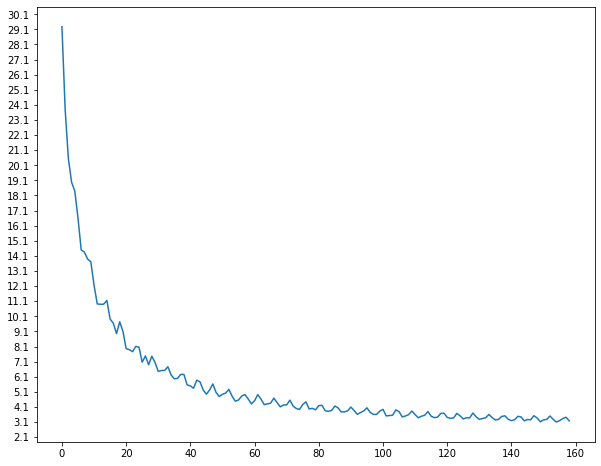

In [35]:
num_steps = 160000
loss=[]
nce_start_time = dt.datetime.now()
embeddings_alpha_35, loss = run(graph, num_steps,1,0.35,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_35_17_JULY_ADAM', embeddings_alpha_35)
plt.figure(figsize=(10, 8))
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
plt.show()

In [ ]:
num_steps = 160000
loss=[]
nce_start_time = dt.datetime.now()
embeddings_alpha_65, loss = run(graph, num_steps,1,0.65,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_65_17_JULY_ADAM', embeddings_alpha_65)
plt.figure(figsize=(10, 8))
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
plt.show()

In [ ]:
num_steps = 160000
loss=[]
nce_start_time = dt.datetime.now()
embeddings_alpha_8, loss = run(graph, num_steps,1,0.8,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_8_17_JULY_ADAM', embeddings_alpha_8)
plt.figure(figsize=(10, 8))
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
plt.show()

In [ ]:
num_steps = 160000
loss=[]
nce_start_time = dt.datetime.now()
embeddings_alpha_1, loss = run(graph, num_steps,1,1.0,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_1_17_JULY_ADAM', embeddings_alpha_1)
plt.figure(figsize=(10, 8))
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
plt.show()

In [39]:
#Saving the dictionary
import json
json = json.dumps(dictionary)
print(len([*dictionary.keys()]))
f = open("word_index_dictionary_for_custom_embeddings_alpha_17_JULY_ADAM.json","w")
f.write(json)
f.close()

12988


# TRIAL CODE FOR FAILURE MEACHANISM (NO NEED TO READ FURHTER)

In [12]:
#Saving the dictionary
import json
json = json.dumps(vocab_dict)
f = open("word_index_dictionary_for_Generic_Skipgram_embeddings_10_June.json","w")
f.write(json)
f.close()

## Lets keep alpha 1 i.e., no taxonomy inference

In [15]:
batch_size = 256
embedding_size = 100  # Dimension of the embedding vector.
skip_window = 5       # How many words to consider left and right.
num_skips = 1         # How many times to reuse an input to generate a label. 

## By reading the blog the understanding of num_skips is that this parameter suggests the
## number of words to be randomly picked from the words in the context neighborhood of 'sat'

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 5    # Number of negative examples to sample.
num_true = 251

In [224]:
# Lets keep alpha 1 i.e., no taxonomy inference

graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[None])
    train_context = tf.placeholder(tf.int32, shape=[None, 1])
    
    input_1 = tf.placeholder(tf.int32, shape=(None))# indices of words to cluster together
    input_2 = tf.placeholder(tf.int32, shape=(None))
    input_3 = tf.placeholder(tf.int32, shape=(None))
    input_4 = tf.placeholder(tf.int32, shape=(None))
    input_5 = tf.placeholder(tf.int32, shape=(None))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    lr = tf.placeholder(tf.float32)
    
  # Look up embeddings for inputs.
    print(embedding_size)
    print(batch_size)
    embeddings = tf.Variable(
      tf.random_normal([vocabulary_size, embedding_size], 0.0, 1.0))
    
#     embed_matrix = tf.get_variable('embed_matrix', 
#                                 shape=[VOCAB_SIZE, EMBED_SIZE],
#                                 initializer=tf.random_uniform_initializer())
    
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    
    
    # Construct the variables for the NCE loss
#     nce_weights = tf.Variable(
#         tf.truncated_normal([vocabulary_size, embedding_size],
#                             stddev=1.0 / math.sqrt(embedding_size)))

    nce_weights = tf.Variable(
    tf.random_normal([vocabulary_size, embedding_size],stddev=1.0, mean=0.0 ))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))


    
    ### 
    nce_loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size ))

#     loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight, 
#                                     biases=nce_bias, 
#                                     labels=target_words, 
#                                     inputs=embed, 
#                                     num_sampled=NUM_SAMPLED, 
#                                     num_classes=VOCAB_SIZE), name='loss')
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(lr,global_step,200, 0.75, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(nce_loss)
    
#    optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    
    normalized_embeddings = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

100
256


In [225]:
loss_ = []
def run(graph, num_steps, lr_, batch_size_, num_skips, skip_window, embedding_size_):
    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
        
        init.run()
        print('Initialized')

        average_loss = 0
        l1 = dict_indices_of_taxonomy['Material failure']
        l2 = dict_indices_of_taxonomy['Control system failure']
        l3 = dict_indices_of_taxonomy['Electrical failure']
        l4 = dict_indices_of_taxonomy['Hydraulic/pneumatic failure']
        l5 = dict_indices_of_taxonomy["Mechanical failure"]
        print(batch_size_)
        print()
        for step in range(num_steps):
            batch_inputs, batch_context = generate_batch(data,
                batch_size_, num_skips, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_context: batch_context, input_1:l1, input_2:l2, 
                         input_3:l3,input_4:l4,input_5:l5, lr:lr_}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
            _, loss_val = session.run([optimizer, nce_loss], feed_dict=feed_dict) #Made a change here
            average_loss += loss_val
            

                        
            if step % 1000 == 0:
                if step > 0:
                    average_loss /= 2000
                  # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    loss_.append(average_loss)
                    average_loss = 0
        
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
        final_embeddings = normalized_embeddings.eval()
        return final_embeddings, loss_
        
        #similarity_=similarity_score.eval()

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_6, loss = run(graph, num_steps,1,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))

In [227]:
np.save('Embeddings_generated_alpha_1_27_MAY_ADAM', embeddings_alpha_6)

In [228]:
#Saving the dictionary
import json
json = json.dumps(dictionary)
print(len([*dictionary.keys()]))
f = open("word_index_dictionary_for_custom_embeddings_alpha_27_MAY_ADAM.json","w")
f.write(json)
f.close()

13648


# Trying with alpha values as well

In [233]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[None])
    train_context = tf.placeholder(tf.int32, shape=[None, 1])
    
    input_1 = tf.placeholder(tf.int32, shape=(None))# indices of words to cluster together
    input_2 = tf.placeholder(tf.int32, shape=(None))
    input_3 = tf.placeholder(tf.int32, shape=(None))
    input_4 = tf.placeholder(tf.int32, shape=(None))
    input_5 = tf.placeholder(tf.int32, shape=(None))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    lr = tf.placeholder(tf.float32)
    alpha_ =  tf.placeholder(tf.float32)
    one_min_alp = 1-alpha_
  # Look up embeddings for inputs.
    print(embedding_size)
    print(batch_size)
    embeddings = tf.Variable(
      tf.random_normal([vocabulary_size, embedding_size], 0.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
   
    
    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.random_normal([vocabulary_size, embedding_size],stddev=1.0, mean=0.0 ))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    distance_1 = fetch_embeddings(embeddings, input_1)
    distance_2 = fetch_embeddings(embeddings, input_2)
    distance_3 = fetch_embeddings(embeddings, input_3)
    distance_4 = fetch_embeddings(embeddings, input_4)
    distance_5 = fetch_embeddings(embeddings, input_5)
    
    dis_pair_1 = dissimilarity_bw_embedings(embeddings, input_1, input_2)
    dis_pair_2 = dissimilarity_bw_embedings(embeddings, input_1, input_3)
    dis_pair_3 = dissimilarity_bw_embedings(embeddings, input_1, input_4)
    dis_pair_4 = dissimilarity_bw_embedings(embeddings, input_1, input_5)
    dis_pair_5 = dissimilarity_bw_embedings(embeddings, input_2, input_3)
    dis_pair_6 = dissimilarity_bw_embedings(embeddings, input_2, input_4)
    dis_pair_7 = dissimilarity_bw_embedings(embeddings, input_2, input_5)
    dis_pair_8 = dissimilarity_bw_embedings(embeddings, input_3, input_4)
    dis_pair_9 = dissimilarity_bw_embedings(embeddings, input_3, input_5)
    dis_pair_10 = dissimilarity_bw_embedings(embeddings, input_4, input_5)
    
    cum_distance_loss = tf.add_n([distance_1,distance_2,distance_3,distance_4,distance_5,dis_pair_1,dis_pair_2,
                         dis_pair_3,dis_pair_4,dis_pair_5,dis_pair_6,dis_pair_7,dis_pair_8,dis_pair_9,dis_pair_10])
    distance_product = tf.math.multiply(one_min_alp,cum_distance_loss)
    ### tf.add_n([tf.math.multiply(0.2,
    nce_loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))
    nce_loss_prod = tf.math.multiply(alpha_,nce_loss)    
    oveall_loss =  tf.add_n([distance_product,nce_loss_prod])
    
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(lr,global_step,200, 0.75, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(oveall_loss)
    

    
    # Compute the cosine similarity between minibatch examples and all embeddings.
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    
    normalized_embeddings = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

100
256


In [234]:
loss_ = []
def run(graph, num_steps, lr_,alpha, batch_size_, num_skips, skip_window, embedding_size_):
    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
        
        init.run()
        print('Initialized')

        average_loss = 0
        l1 = dict_indices_of_taxonomy['Material failure']
        l2 = dict_indices_of_taxonomy['Control system failure']
        l3 = dict_indices_of_taxonomy['Electrical failure']
        l4 = dict_indices_of_taxonomy['Hydraulic/pneumatic failure']
        l5 = dict_indices_of_taxonomy["Mechanical failure"]
        
        for step in range(num_steps):
            batch_inputs, batch_context = generate_batch(data,
                batch_size, num_skips, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_context: batch_context, input_1:l1, input_2:l2, 
                         input_3:l3,input_4:l4,input_5:l5, lr:lr_, alpha_:alpha}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
            _, loss_val = session.run([optimizer, nce_loss], feed_dict=feed_dict) #Made a change here
            average_loss += loss_val
            
            
            if step % 2000 == 0:
                if step > 0:
                    average_loss /= 2000
                  # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    loss_.append(average_loss)
                    average_loss = 0
        
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
        final_embeddings = normalized_embeddings.eval()
        return final_embeddings, loss_
        
        #similarity_=similarity_score.eval()

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_6, loss = run(graph, num_steps,1,0.5,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))

In [236]:
np.save('Embeddings_generated_alpha_5_27_MAY_ADAM', embeddings_alpha_6)

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_2, loss = run(graph, num_steps,1,0.2,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_2_27_MAY_ADAM', embeddings_alpha_2)

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_35, loss = run(graph, num_steps,1,0.35,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_35_27_MAY_ADAM', embeddings_alpha_35)

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_65, loss = run(graph, num_steps,1,0.65,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_65_27_MAY_ADAM', embeddings_alpha_65)

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_8, loss = run(graph, num_steps,1,0.8,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_8_27_MAY_ADAM', embeddings_alpha_8)

In [ ]:
#################################----------------------------------------------------########################################

# Incorporating the exponential decay in LR and dividing by embedding_size

In [19]:
# Lets keep alpha 1 i.e., no taxonomy inference

graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[None])
    train_context = tf.placeholder(tf.int32, shape=[None, 1])
    
    input_1 = tf.placeholder(tf.int32, shape=(None))# indices of words to cluster together
    input_2 = tf.placeholder(tf.int32, shape=(None))
    input_3 = tf.placeholder(tf.int32, shape=(None))
    input_4 = tf.placeholder(tf.int32, shape=(None))
    input_5 = tf.placeholder(tf.int32, shape=(None))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    lr = tf.placeholder(tf.float32)
    
  # Look up embeddings for inputs.
    print(embedding_size)
    print(batch_size)
    embeddings = tf.Variable(
      tf.random_normal([vocabulary_size, embedding_size], 0.0, 1.0))

    
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)



    nce_weights = tf.Variable(
    tf.random_normal([vocabulary_size, embedding_size],stddev=1.0, mean=0.0 ))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))


    
    ### 
    nce_loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size ))


    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(lr,global_step,200, 0.875, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(nce_loss)

    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    
    normalized_embeddings = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)


    init = tf.global_variables_initializer()

100
256


In [20]:
loss_ = []
def run(graph, num_steps, lr_, batch_size_, num_skips, skip_window, embedding_size_):
    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
        
        init.run()
        print('Initialized')

        average_loss = 0
        l1 = dict_indices_of_taxonomy['Material failure']
        l2 = dict_indices_of_taxonomy['Control system failure']
        l3 = dict_indices_of_taxonomy['Electrical failure']
        l4 = dict_indices_of_taxonomy['Hydraulic/pneumatic failure']
        l5 = dict_indices_of_taxonomy["Mechanical failure"]
        print(batch_size_)
        print()
        for step in range(num_steps):
            batch_inputs, batch_context = generate_batch(data,
                batch_size_, num_skips, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_context: batch_context, input_1:l1, input_2:l2, 
                         input_3:l3,input_4:l4,input_5:l5, lr:lr_}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
            _, loss_val = session.run([optimizer, nce_loss], feed_dict=feed_dict) #Made a change here
            average_loss += loss_val
            
                       
            if step % 1000 == 0:
                if step > 0:
                    average_loss /= 2000
                  # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    loss_.append(average_loss)
                    average_loss = 0
        
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
        final_embeddings = normalized_embeddings.eval()
        return final_embeddings, loss_
        
        #similarity_=similarity_score.eval()

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_6, loss = run(graph, num_steps,1,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))

In [22]:
np.save('Embeddings_generated_alpha_1_28_MAY_ADAM', embeddings_alpha_6)

In [23]:
#Saving the dictionary
import json
json = json.dumps(dictionary)
print(len([*dictionary.keys()]))
f = open("word_index_dictionary_for_custom_embeddings_alpha_28_MAY_ADAM.json","w")
f.write(json)
f.close()

13648


In [39]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[None])
    train_context = tf.placeholder(tf.int32, shape=[None, 1])
    
    input_1 = tf.placeholder(tf.int32, shape=(None))# indices of words to cluster together
    input_2 = tf.placeholder(tf.int32, shape=(None))
    input_3 = tf.placeholder(tf.int32, shape=(None))
    input_4 = tf.placeholder(tf.int32, shape=(None))
    input_5 = tf.placeholder(tf.int32, shape=(None))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    lr = tf.placeholder(tf.float32)
    alpha_ =  tf.placeholder(tf.float32)
    one_min_alp = 1-alpha_
  # Look up embeddings for inputs.
    print(embedding_size)
    print(batch_size)
    embeddings = tf.Variable(
      tf.random_normal([vocabulary_size, embedding_size], 0.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
   
    
    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.random_normal([vocabulary_size, embedding_size],stddev=1.0, mean=0.0 ))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    distance_1 = fetch_embeddings(embeddings, input_1)
    distance_2 = fetch_embeddings(embeddings, input_2)
    distance_3 = fetch_embeddings(embeddings, input_3)
    distance_4 = fetch_embeddings(embeddings, input_4)
    distance_5 = fetch_embeddings(embeddings, input_5)
    
    dis_pair_1 = dissimilarity_bw_embedings(embeddings, input_1, input_2)
    dis_pair_2 = dissimilarity_bw_embedings(embeddings, input_1, input_3)
    dis_pair_3 = dissimilarity_bw_embedings(embeddings, input_1, input_4)
    dis_pair_4 = dissimilarity_bw_embedings(embeddings, input_1, input_5)
    dis_pair_5 = dissimilarity_bw_embedings(embeddings, input_2, input_3)
    dis_pair_6 = dissimilarity_bw_embedings(embeddings, input_2, input_4)
    dis_pair_7 = dissimilarity_bw_embedings(embeddings, input_2, input_5)
    dis_pair_8 = dissimilarity_bw_embedings(embeddings, input_3, input_4)
    dis_pair_9 = dissimilarity_bw_embedings(embeddings, input_3, input_5)
    dis_pair_10 = dissimilarity_bw_embedings(embeddings, input_4, input_5)
    
    cum_distance_loss = tf.add_n([distance_1,distance_2,distance_3,distance_4,distance_5,dis_pair_1,dis_pair_2,
                         dis_pair_3,dis_pair_4,dis_pair_5,dis_pair_6,dis_pair_7,dis_pair_8,dis_pair_9,dis_pair_10])
    distance_product = tf.math.multiply(one_min_alp,cum_distance_loss)
    ### tf.add_n([tf.math.multiply(0.2,
    nce_loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))
    nce_loss_prod = tf.math.multiply(alpha_,nce_loss)    
    oveall_loss =  tf.add_n([distance_product,nce_loss_prod])
    
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(lr,global_step,200, 0.875, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(oveall_loss)
    

    
    # Compute the cosine similarity between minibatch examples and all embeddings.
    
    # norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    
    # normalized_embeddings = embeddings / norm
    
    #valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    valid_embeddings = tf.nn.embedding_lookup(embeddings, valid_dataset)
    #similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    similarity = tf.matmul(valid_embeddings, embeddings, transpose_b=True)
    

    # Add variable initializer.
    init = tf.global_variables_initializer()        

100
256


In [40]:
loss_ = []
def run(graph, num_steps, lr_,alpha, batch_size_, num_skips, skip_window, embedding_size_):
    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
        
        init.run()
        print('Initialized')

        average_loss = 0
        l1 = dict_indices_of_taxonomy['Material failure']
        l2 = dict_indices_of_taxonomy['Control system failure']
        l3 = dict_indices_of_taxonomy['Electrical failure']
        l4 = dict_indices_of_taxonomy['Hydraulic/pneumatic failure']
        l5 = dict_indices_of_taxonomy["Mechanical failure"]
        
        for step in range(num_steps):
            batch_inputs, batch_context = generate_batch(data,
                batch_size, num_skips, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_context: batch_context, input_1:l1, input_2:l2, 
                         input_3:l3,input_4:l4,input_5:l5, lr:lr_, alpha_:alpha}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
            _, loss_val = session.run([optimizer, nce_loss], feed_dict=feed_dict) #Made a change here
            average_loss += loss_val
            
            
            if step % 2000 == 0:
                if step > 0:
                    average_loss /= 2000
                  # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    loss_.append(average_loss)
                    average_loss = 0
        
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
        #final_embeddings = normalized_embeddings.eval()
        final_embeddings = embeddings.eval()
        return final_embeddings, loss_
        
        #similarity_=similarity_score.eval()

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_6, loss = run(graph, num_steps,1,1.0,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_1_28_MAY_ADAM', embeddings_alpha_6)

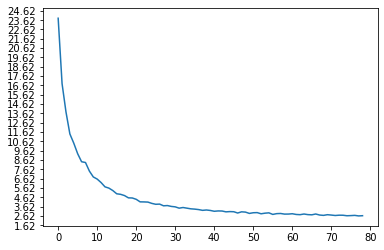

In [47]:
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
#plt.yticks(0, len(loss)+1)
plt.show()

In [44]:
len(loss)

79

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_6, loss = run(graph, num_steps,1,0.5,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_5_28_MAY_ADAM', embeddings_alpha_6)

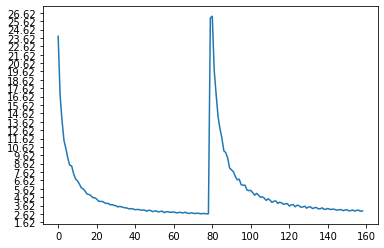

In [50]:
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
#plt.yticks(0, len(loss)+1)
plt.show()

In [51]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_6, loss = run(graph, num_steps,1,0.2,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_2_28_MAY_ADAM', embeddings_alpha_6)

Initialized
Nearest to part: bob, makebreak, ladder, bask, retune, tghat, tubeinstalled, masm,
Nearest to oil: thew, deviced, heate, anticipate, occurr, safely, crabtree, wirirng,
Nearest to create: ignorerelease, radial, bon, tubescope, eltechdindeepwatercom, pessanha, vah, preset,
Nearest to cable: mgs, memtestiso, selfinduced, ron, inserts, address, conex, construe,
Nearest to work: varghese, cog, wand, rely, bounce, alowed, interpret, pipedbs,
Nearest to top: baldor, readbacks, sdcoil, control, schlumberger, ibops, lockclips, accomodate,
Nearest to cylinder: showed, amerson, tally, joystic, countoil, assemaly, advisor, troubleshootingets,
Nearest to get: discoverer, readt, calibrated, leaking, obstruct, pushlok, transmitterblock, reported,
Nearest to low: horsepower, gearboxmain, subrod, separatly, hpts, cur, chage, tongue,
Nearest to psi: unavailability, reattach, ltrs, undertaken, arranged, reject, early, dshackle,
Nearest to operating: inputoutput, journal, switcjh, allspare, co

Average loss at step  44000 :  7.735950956642628
Average loss at step  46000 :  7.3553021385073665
Average loss at step  48000 :  7.619258630156517
Average loss at step  50000 :  6.916131511807442
Nearest to part: specification, technology, auto, configuration, non, tear, operating, swab,
Nearest to oil: technology, lube, specification, configuration, operability, cancel, tear, row,
Nearest to create: specification, technology, operability, shape, cancel, slot, tear, operating,
Nearest to cable: bending, distortion, interruption, shrink, disconnection, looseness, clearance, seizure,
Nearest to work: configuration, technology, slot, cancel, operability, tear, shape, operating,
Nearest to top: specification, configuration, operability, lube, swab, slot, cancel, tear,
Nearest to cylinder: specification, slot, configuration, swab, row, cancel, operability, tear,
Nearest to get: configuration, technology, slot, cancel, shape, tear, operability, operating,
Nearest to low: slot, configuration

Average loss at step  92000 :  4.957507589399815
Average loss at step  94000 :  4.542285605490208
Average loss at step  96000 :  4.724049420416355
Average loss at step  98000 :  4.811802727162838
Average loss at step  100000 :  4.413923700213433
Nearest to part: operability, shape, swab, maintainability, category, configuration, simultaneously, priority,
Nearest to oil: operability, lube, maintainability, swab, simultaneously, configuration, predominant, shape,
Nearest to create: operability, shape, simultaneously, configuration, maintainability, responsible, swab, category,
Nearest to cable: bending, distortion, interruption, shrink, disconnection, looseness, clearance, seizure,
Nearest to work: operability, shape, maintainability, configuration, category, swab, simultaneously, fall,
Nearest to top: operability, swab, simultaneously, category, maintainability, lube, shape, configuration,
Nearest to cylinder: operability, swab, shape, maintainability, bay, configuration, slot, category

Average loss at step  138000 :  3.826227754890919
Average loss at step  140000 :  4.01620157468319
Nearest to part: simultaneously, operability, predominant, maintainability, shape, attribute, category, priority,
Nearest to oil: operability, lube, predominant, simultaneously, adapter, attribute, maintainability, wear,
Nearest to create: simultaneously, operability, responsible, predominant, operationuse, shape, index, category,
Nearest to cable: bending, distortion, interruption, shrink, disconnection, looseness, clearance, seizure,
Nearest to work: operability, simultaneously, predominant, shape, maintainability, index, operationuse, category,
Nearest to top: simultaneously, operability, predominant, category, wear, swab, maintainability, bay,
Nearest to cylinder: operability, simultaneously, predominant, wear, maintainability, shape, pneumatic, category,
Nearest to get: operability, simultaneously, predominant, shape, maintainability, category, operationuse, sae,
Nearest to low: oper

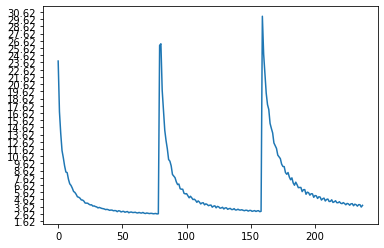

In [52]:
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
#plt.yticks(0, len(loss)+1)
plt.show()

In [53]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_6, loss = run(graph, num_steps,1,0.35,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_35_28_MAY_ADAM', embeddings_alpha_6)

Initialized
Nearest to part: booster, foundin, inevitable, alternate, motor, youll, air, positionpreset,
Nearest to oil: distace, tack, weekly, volts, wrnech, bundle, pertiles, awaitting,
Nearest to create: business, smooth, diapragm, unwanted, rstc, slipplage, alarrm, reload,
Nearest to cable: wirng, backlite, quill, repaired, obersed, carptenter, jax, spinniing,
Nearest to work: stna, severeal, rcd, reliable, touchscreen, hanes, gouging, extent,
Nearest to top: oportunity, voyage, tarpauling, tenionser, oversight, choice, systen, kgaa,
Nearest to cylinder: allblower, dwx, slb, conduted, modify, visite, everytiime, upeer,
Nearest to get: deferals, reliability, endarance, over, ssgd, touchpad, cpv, preocedure,
Nearest to low: baseplate, across, arman, electrically, repositioning, chpu, dump, violently,
Nearest to psi: ftibs, remeggered, type, mist, decel, lash, ivestigation, irmohms,
Nearest to operating: lodged, swithc, carriage, senior, ovveride, fastners, cur, mehcanics,
Nearest to 

Average loss at step  42000 :  6.228553737163543
Average loss at step  44000 :  5.856810379385948
Average loss at step  46000 :  5.631193711578846
Average loss at step  48000 :  5.583092080950737
Average loss at step  50000 :  5.511583123862743
Nearest to part: shape, technology, maintainability, configuration, urethane, applies, sheave, text,
Nearest to oil: shape, technology, lube, swab, urethane, maintainability, configuration, responsible,
Nearest to create: shape, technology, maintainability, configuration, applies, responsible, capacity, common,
Nearest to cable: interruption, cavitation, seizure, voltage, deformation, disconnection, looseness, shrink,
Nearest to work: shape, technology, maintainability, applies, configuration, urethane, tested, responsible,
Nearest to top: shape, maintainability, technology, urethane, configuration, responsible, swab, lube,
Nearest to cylinder: shape, technology, urethane, maintainability, configuration, applies, swab, responsible,
Nearest to ge

Average loss at step  92000 :  4.0306292132139205
Average loss at step  94000 :  3.7312448446154596
Average loss at step  96000 :  3.840839721262455
Average loss at step  98000 :  3.9079885568022728
Average loss at step  100000 :  3.686834040403366
Nearest to part: urethane, technology, shape, simultaneously, alertness, revise, index, adequacy,
Nearest to oil: operability, choice, capacity, technology, regulator, simultaneously, filtration, alertness,
Nearest to create: simultaneously, index, capacity, urethane, adequacy, operability, technology, operationuse,
Nearest to cable: cable, interruption, wire, power, seizure, cavitation, voltage, vibration,
Nearest to work: urethane, operability, technology, adequacy, index, choice, capacity, alertness,
Nearest to top: choice, urethane, container, double, adequacy, operability, revise, blow,
Nearest to cylinder: simultaneously, choice, container, operability, adequacy, cyl, alertness, technology,
Nearest to get: simultaneously, operability, 

Average loss at step  142000 :  3.38356330627203
Average loss at step  144000 :  3.186713053107262
Average loss at step  146000 :  3.339452158153057
Average loss at step  148000 :  3.3588117715120314
Average loss at step  150000 :  3.1214207676053047
Nearest to part: rhll, simultaneously, alertness, adequacy, revise, improperly, choice, api,
Nearest to oil: alertness, choice, simultaneously, filtration, female, comp, audit, pneumatic,
Nearest to create: alertness, simultaneously, adequacy, audit, index, urethane, improperly, revise,
Nearest to cable: bending, power, wire, vibration, interruption, seizure, cavitation, stick,
Nearest to work: alertness, simultaneously, adequacy, choice, revise, medium, windows, index,
Nearest to top: choice, simultaneously, adequacy, alertness, oos, container, audit, revise,
Nearest to cylinder: alertness, simultaneously, choice, container, double, windows, adequacy, oos,
Nearest to get: choice, simultaneously, rollout, adequacy, alertness, rhll, medium,

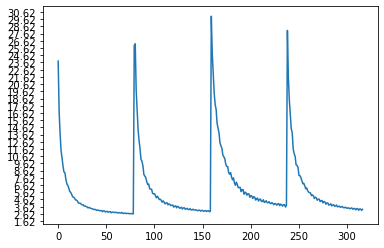

In [54]:
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
#plt.yticks(0, len(loss)+1)
plt.show()

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_6, loss = run(graph, num_steps,1,0.65,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_65_28_MAY_ADAM', embeddings_alpha_6)

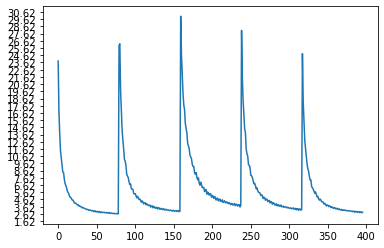

In [56]:
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
#plt.yticks(0, len(loss)+1)
plt.show()

In [ ]:
num_steps = 160000
nce_start_time = dt.datetime.now()
embeddings_alpha_6, loss = run(graph, num_steps,1,0.8,256,1,5,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))
np.save('Embeddings_generated_alpha_8_28_MAY_ADAM', embeddings_alpha_6)

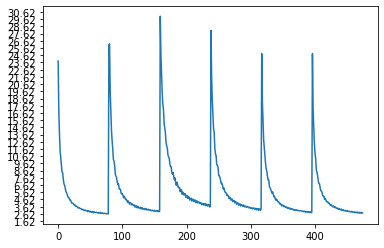

In [58]:
plt.plot(loss)
plt.yticks(np.arange(min(loss)-1, max(loss)+1, 1.0))
#plt.yticks(0, len(loss)+1)
plt.show()

In [ ]:
num_steps = 8000
nce_start_time = dt.datetime.now()

batch_sizes = [128,256,512,1024,2048,4096]
loss_com = []
for batch in batch_sizes:
    embeddings_alpha_6, loss = run(graph, num_steps,0.01,batch,1,5,100)
    loss_com.append(loss)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))

In [63]:
print(len(loss_com))

6


In [77]:
print(loss_com[0])
print(loss_com[1])
print(loss_com[2])
print(loss_com[3])

[22431.503487348557, 18544.118376255035, 16218.18738436699, 14713.338215827942, 13667.892306923866, 12854.899346709251, 12282.438936471939, 11216.1607670784, 10626.784064769745, 10714.282159924507, 10411.373794198036, 22280.302269220352, 18248.932069659233, 16183.474751353264, 14631.300834536552, 13045.770267009735, 12610.144694566727, 12276.009032011032, 22026.169321775436, 18455.797492027283, 16564.811032176018, 14750.905982255936, 13875.776465296745, 13421.938193917274, 11889.757315635681, 23082.902557492256, 18461.403004288673, 16062.381132602692, 14734.021315932274, 13618.184370040894, 13190.570505976677, 11765.238921046257, 22956.975758314133, 18864.435996890068, 16474.234776854515, 14407.821073532104, 13338.178133130074, 13131.048830509186, 12212.104170084, 22997.272747159004, 19072.002626895905, 16106.374262571335, 14226.004306793213, 13585.928269028664, 12004.06809413433, 11265.24953353405, 23338.413442254066, 18370.78477013111, 16143.400159955025, 14732.51872766018, 12970.611

Text(0.5, 1.0, 'batch 4096')

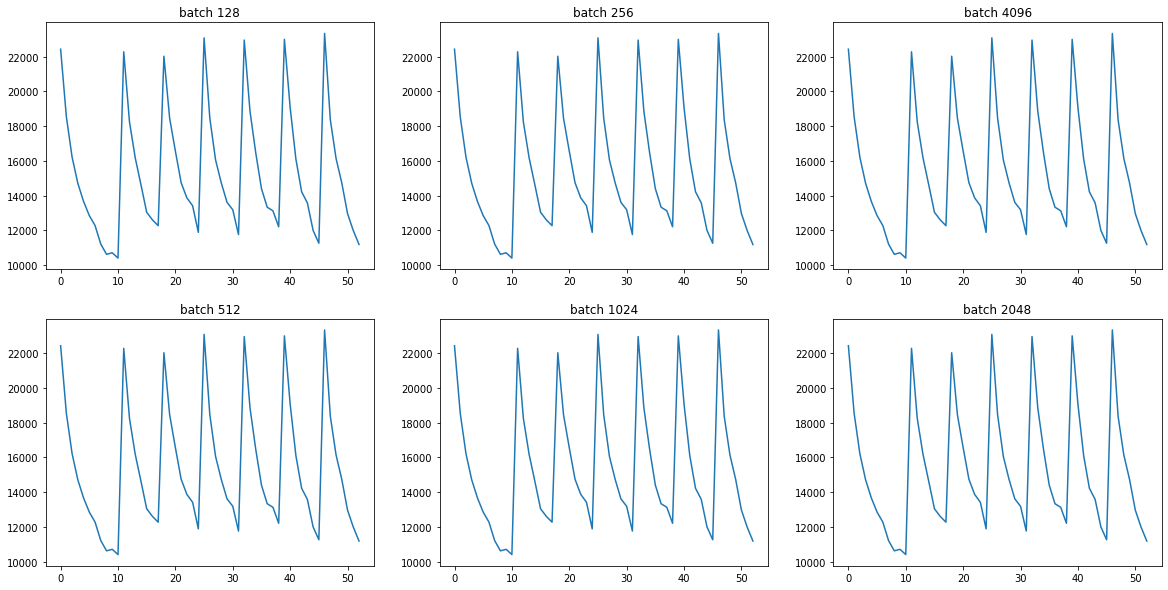

In [75]:
fig, axs = plt.subplots(2, 3, figsize = (20,10))
axs[0, 0].plot(loss_com[0])
axs[0, 0].set_title('batch 128')
axs[0, 1].plot(loss_com[1])
axs[0, 1].set_title('batch 256')
axs[1, 0].plot(loss_com[2])
axs[1, 0].set_title('batch 512')
axs[1, 1].plot(loss_com[3])
axs[1, 1].set_title('batch 1024')
axs[1, 2].plot(loss_com[4])
axs[1, 2].set_title('batch 2048')
axs[0, 2].plot(loss_com[5])
axs[0, 2].set_title('batch 4096')
               

In [78]:
num_steps = 8000
nce_start_time = dt.datetime.now()

#batch_sizes = [128,256,512,1024,2048,4096]
window_size = [4,6,8]
loss_com = []
for win in window_size:
    embeddings_alpha_6, loss = run(graph, num_steps,0.01,256,1,win,100)
    loss_com.append(loss)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))

Initialized
256
4
Nearest to close: organise, cabo, endoders, repiar, rotational, partstop, latcher, put,
Nearest to run: vacuum, extrenal, tabs, oily, excel, spetember, although, verifcation,
Nearest to drive: travleing, closedsecondary, improperly, container, hinge, gsa, injured, really,
Nearest to rig: faulted, rheostat, reamer, fasteninmg, danger, invert, pickup, oon,
Nearest to non: grub, diederik, agdr, traveling, lasting, thory, simon, presentation,
Nearest to mud: phprsxxx, twelve, oddity, shanemcclaughertydeepwatercom, result, nylock, decending, atnernate,
Nearest to assembly: functionality, asc, connecton, bleed, onthe, asmebly, norgren, downwards,
Nearest to position: foud, devicetrak, cannister, cassettte, transducer, elevate, initially, nearly,
Nearest to specification: telscoping, drawwokrs, damagedir, tree, touch, gom, proposed, glass,
Nearest to replace: interanl, mulitiple, experianced, pic, incorporates, sooner, genius, relabel,
Nearest to change: idle, portaft, point

Text(0.5, 1.0, 'batch 1024')

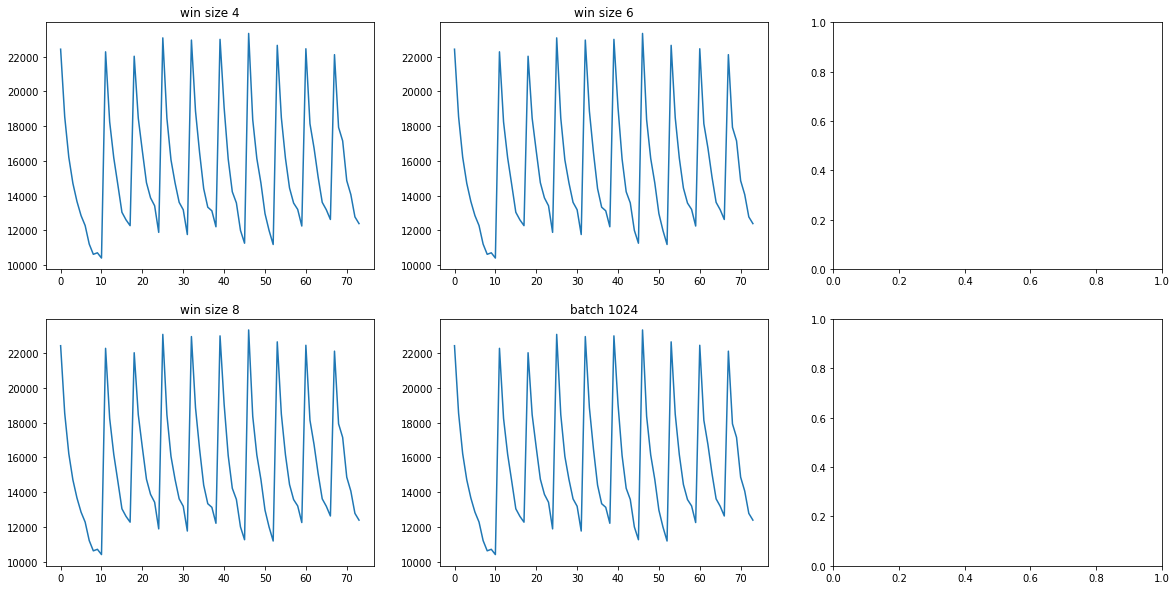

In [80]:
fig, axs = plt.subplots(2, 3, figsize = (20,10))
axs[0, 0].plot(loss_com[0])
axs[0, 0].set_title('win size 4')
axs[0, 1].plot(loss_com[1])
axs[0, 1].set_title('win size 6')
axs[1, 0].plot(loss_com[2])
axs[1, 0].set_title('win size 8')
axs[1, 1].plot(loss_com[2])
axs[1, 1].set_title('batch 1024')

In [100]:
#np.save('Embeddings_generated_alpha_1_23_MAY_ADAM', embeddings_alpha_6)

In [ ]:
# Trying with alpha = 0.3

In [102]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[None])
    train_context = tf.placeholder(tf.int32, shape=[None, 1])
    
    input_1 = tf.placeholder(tf.int32, shape=(None))# indices of words to cluster together
    input_2 = tf.placeholder(tf.int32, shape=(None))
    input_3 = tf.placeholder(tf.int32, shape=(None))
    input_4 = tf.placeholder(tf.int32, shape=(None))
    input_5 = tf.placeholder(tf.int32, shape=(None))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    lr = tf.placeholder(tf.float32)
    
  # Look up embeddings for inputs.
    print(embedding_size)
    print(batch_size)
    embeddings = tf.Variable(
      tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
   
    
    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    distance_1 = fetch_embeddings(embeddings, input_1)
    distance_2 = fetch_embeddings(embeddings, input_2)
    distance_3 = fetch_embeddings(embeddings, input_3)
    distance_4 = fetch_embeddings(embeddings, input_4)
    distance_5 = fetch_embeddings(embeddings, input_5)
    
    dis_pair_1 = dissimilarity_bw_embedings(embeddings, input_1, input_2)
    dis_pair_2 = dissimilarity_bw_embedings(embeddings, input_1, input_3)
    dis_pair_3 = dissimilarity_bw_embedings(embeddings, input_1, input_4)
    dis_pair_4 = dissimilarity_bw_embedings(embeddings, input_1, input_5)
    dis_pair_5 = dissimilarity_bw_embedings(embeddings, input_2, input_3)
    dis_pair_6 = dissimilarity_bw_embedings(embeddings, input_2, input_4)
    dis_pair_7 = dissimilarity_bw_embedings(embeddings, input_2, input_5)
    dis_pair_8 = dissimilarity_bw_embedings(embeddings, input_3, input_4)
    dis_pair_9 = dissimilarity_bw_embedings(embeddings, input_3, input_5)
    dis_pair_10 = dissimilarity_bw_embedings(embeddings, input_4, input_5)
    
    ### 
    nce_loss = tf.add_n([tf.math.multiply(0.7,tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))),
                         tf.math.multiply(0.3, distance_1),
                         tf.math.multiply(0.3,distance_2),
                         tf.math.multiply(0.3,distance_3),
                         tf.math.multiply(0.3,distance_4),
                         tf.math.multiply(0.3,distance_5),
                         tf.math.multiply(0.3,dis_pair_1),
                         tf.math.multiply(0.3,dis_pair_2),
                         tf.math.multiply(0.3,dis_pair_3),
                         tf.math.multiply(0.3,dis_pair_4),
                         tf.math.multiply(0.3,dis_pair_5),
                         tf.math.multiply(0.3,dis_pair_6),
                         tf.math.multiply(0.3,dis_pair_7),
                         tf.math.multiply(0.3,dis_pair_8),
                         tf.math.multiply(0.3,dis_pair_9),
                         tf.math.multiply(0.3,dis_pair_10)])

    optimizer = tf.train.AdamOptimizer(lr).minimize(nce_loss)
    
    # Compute the cosine similarity between minibatch examples and all embeddings.
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    
    normalized_embeddings = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

100
128


In [103]:
loss_ = []
def run(graph, num_steps, lr_, batch_size_, num_skips, skip_window, embedding_size_):
    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
        
        init.run()
        print('Initialized')

        average_loss = 0
        l1 = dict_indices_of_taxonomy['Material failure']
        l2 = dict_indices_of_taxonomy['Control system failure']
        l3 = dict_indices_of_taxonomy['Electrical failure']
        l4 = dict_indices_of_taxonomy['Hydraulic/pneumatic failure']
        l5 = dict_indices_of_taxonomy["Mechanical failure"]
        
        for step in range(num_steps):
            batch_inputs, batch_context = generate_batch(data,
                batch_size, num_skips, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_context: batch_context, input_1:l1, input_2:l2, 
                         input_3:l3,input_4:l4,input_5:l5, lr:lr_}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
            _, loss_val = session.run([optimizer, nce_loss], feed_dict=feed_dict) #Made a change here
            average_loss += loss_val
            
            
            if step % 2000 == 0:
                if step > 0:
                    average_loss /= 2000
                  # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    loss_.append(average_loss)
                    average_loss = 0
        
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
        final_embeddings = normalized_embeddings.eval()
        return final_embeddings, loss_
        
        #similarity_=similarity_score.eval()

In [ ]:
num_steps = 100000
nce_start_time = dt.datetime.now()
embeddings_alpha_2, loss = run(graph, num_steps,0.01,200,4,2,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))

In [106]:
np.save('Embeddings_generated_alpha_0.7_23_MAY_ADAM', embeddings_alpha_2)

In [107]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[None])
    train_context = tf.placeholder(tf.int32, shape=[None, 1])
    
    input_1 = tf.placeholder(tf.int32, shape=(None))# indices of words to cluster together
    input_2 = tf.placeholder(tf.int32, shape=(None))
    input_3 = tf.placeholder(tf.int32, shape=(None))
    input_4 = tf.placeholder(tf.int32, shape=(None))
    input_5 = tf.placeholder(tf.int32, shape=(None))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    lr = tf.placeholder(tf.float32)
    
  # Look up embeddings for inputs.
    print(embedding_size)
    print(batch_size)
    embeddings = tf.Variable(
      tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
   
    
    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    distance_1 = fetch_embeddings(embeddings, input_1)
    distance_2 = fetch_embeddings(embeddings, input_2)
    distance_3 = fetch_embeddings(embeddings, input_3)
    distance_4 = fetch_embeddings(embeddings, input_4)
    distance_5 = fetch_embeddings(embeddings, input_5)
    
    dis_pair_1 = dissimilarity_bw_embedings(embeddings, input_1, input_2)
    dis_pair_2 = dissimilarity_bw_embedings(embeddings, input_1, input_3)
    dis_pair_3 = dissimilarity_bw_embedings(embeddings, input_1, input_4)
    dis_pair_4 = dissimilarity_bw_embedings(embeddings, input_1, input_5)
    dis_pair_5 = dissimilarity_bw_embedings(embeddings, input_2, input_3)
    dis_pair_6 = dissimilarity_bw_embedings(embeddings, input_2, input_4)
    dis_pair_7 = dissimilarity_bw_embedings(embeddings, input_2, input_5)
    dis_pair_8 = dissimilarity_bw_embedings(embeddings, input_3, input_4)
    dis_pair_9 = dissimilarity_bw_embedings(embeddings, input_3, input_5)
    dis_pair_10 = dissimilarity_bw_embedings(embeddings, input_4, input_5)
    
    ### 
    nce_loss = tf.add_n([tf.math.multiply(0.3,tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))),
                         tf.math.multiply(0.7, distance_1),
                         tf.math.multiply(0.7,distance_2),
                         tf.math.multiply(0.7,distance_3),
                         tf.math.multiply(0.7,distance_4),
                         tf.math.multiply(0.7,distance_5),
                         tf.math.multiply(0.7,dis_pair_1),
                         tf.math.multiply(0.7,dis_pair_2),
                         tf.math.multiply(0.7,dis_pair_3),
                         tf.math.multiply(0.7,dis_pair_4),
                         tf.math.multiply(0.7,dis_pair_5),
                         tf.math.multiply(0.7,dis_pair_6),
                         tf.math.multiply(0.7,dis_pair_7),
                         tf.math.multiply(0.7,dis_pair_8),
                         tf.math.multiply(0.7,dis_pair_9),
                         tf.math.multiply(0.7,dis_pair_10)])

    optimizer = tf.train.AdamOptimizer(lr).minimize(nce_loss)
    
    # Compute the cosine similarity between minibatch examples and all embeddings.
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    
    normalized_embeddings = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

100
128


In [108]:
loss_ = []
def run(graph, num_steps, lr_, batch_size_, num_skips, skip_window, embedding_size_):
    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
        
        init.run()
        print('Initialized')

        average_loss = 0
        l1 = dict_indices_of_taxonomy['Material failure']
        l2 = dict_indices_of_taxonomy['Control system failure']
        l3 = dict_indices_of_taxonomy['Electrical failure']
        l4 = dict_indices_of_taxonomy['Hydraulic/pneumatic failure']
        l5 = dict_indices_of_taxonomy["Mechanical failure"]
        
        for step in range(num_steps):
            batch_inputs, batch_context = generate_batch(data,
                batch_size, num_skips, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_context: batch_context, input_1:l1, input_2:l2, 
                         input_3:l3,input_4:l4,input_5:l5, lr:lr_}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
            _, loss_val = session.run([optimizer, nce_loss], feed_dict=feed_dict) #Made a change here
            average_loss += loss_val
            
            
            if step % 2000 == 0:
                if step > 0:
                    average_loss /= 2000
                  # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    loss_.append(average_loss)
                    average_loss = 0
        
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
        final_embeddings = normalized_embeddings.eval()
        return final_embeddings, loss_
        
        #similarity_=similarity_score.eval()

In [109]:
num_steps = 50000
nce_start_time = dt.datetime.now()
embeddings_alpha_3, loss = run(graph, num_steps,0.01,200,4,2,100)
nce_end_time = dt.datetime.now()
print("NCE method took {} minutes to run 100 iterations".format((nce_end_time-nce_start_time).total_seconds()))

Initialized
Nearest to time: exhibit, overwrite, unknown, vertical, reseated, gunge, attempths, instant,
Nearest to low: judge, operating, hqsopstibphm, ddkg, gripper, undertaken, boltskeepsaccessories, vac,
Nearest to cause: january, sloppy, kinertic, ses, qaqc, sphere, destructive, usb,
Nearest to valve: throught, subs, depart, rbs, opene, matrix, menu, graph,
Nearest to position: hindges, trash, commander, shrader, kit, divt, resistor, cartage,
Nearest to drive: funtionality, majority, realize, look, documentation, syncronization, foward, skip,
Nearest to set: requisition, fold, cooler, needle, recheck, divide, compress, ext,
Nearest to drill: differ, accidently, lifted, serval, circlip, maclean, kelly, hwy,
Nearest to cancel: sam, accept, availability, recalibratioin, temporarily, torqueing, squeaking, weather,
Nearest to back: stds, pert, changijng, methodology, ringmain, turnbuckle, battery, true,
Nearest to pipework: onboard, assocoiated, alower, differ, purchasing, hydrackers, 

In [110]:
np.save('Embeddings_generated_alpha_0.3_23_MAY_ADAM', embeddings_alpha_3)